# NHL Game Predictor
##### **Still in progress**
This is my attempt at a KNN NHL game predictor, using the KNN class I coded.
### Important Notes
* When I use the year, it refers to the year the season ends.
    * Like for example the 2024-2025 is marked as 2025.
* nhl-XX.csv is the score data for a given season.
    * Links to get this data is as follows:
      * [2022 Season](https://shanemcd.org/2021/09/23/2021-22-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2023 Season](https://shanemcd.org/2022/07/12/2022-23-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2024 Season](https://shanemcd.org/2023/08/23/2023-24-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2025 Season](https://shanemcd.org/2024/09/07/2024-25-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * All on shanemcd.org, note that I have to redownload the 2025 season data for updated results (csv download of course).
* teamsXX.csv is the team data for a given season.
    * Links to the data is from [MoneyPuck.com](https://moneypuck.com/data.htm)
    * Downloads are from the Team Level

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from knn import KNN
pd.set_option('display.max_columns', None)

### getTeam(abbreviation)
This returns the team name given the abbrevation

In [3]:
abbrev = pd.read_csv("abbreviations.csv")
abbrev.index = abbrev["Abbrev"]
abbrev = abbrev.drop("Abbrev", axis=1)
abbrev = abbrev.to_dict("index")
abbrev = {k: v['Team'] for k, v in abbrev.items()}
abbrev
def getTeam(text):
    text = text.upper()
    return abbrev[text]

The cell bellow imports the game data and makes only gets the score and winner

In [4]:
def import_games(file):
    game_data = pd.read_csv(file)
    game_data = game_data[game_data["Status"] != "Scheduled"]
    game_data = game_data.rename(columns={"Score": "AwayScore", "Score.1": "HomeScore","Visitor": "Away"})
    game_data["HomeWin"] = game_data["HomeScore"] > game_data["AwayScore"]
    game_data["HomeWin"] = game_data["HomeWin"].astype(int)
    game_data = game_data[["Away","AwayScore","Home","HomeScore","HomeWin"]]
    return game_data
games22 = import_games("nhl-22.csv")
games23 = import_games("nhl-23.csv")
games24 = import_games("nhl-24.csv")
games25 = import_games("nhl-25.csv")
games25

,Away,AwayScore,Home,HomeScore,HomeWin
0,New Jersey Devils,4.0,Buffalo Sabres,1.0,0
1,Buffalo Sabres,1.0,New Jersey Devils,3.0,1
2,St. Louis Blues,3.0,Seattle Kraken,2.0,0
3,Boston Bruins,4.0,Florida Panthers,6.0,1
4,Chicago Blackhawks,2.0,Utah Hockey Club,5.0,1
...,...,...,...,...,...
418,Seattle Kraken,2.0,New Jersey Devils,3.0,1
419,Pittsburgh Penguins,2.0,New York Rangers,4.0,1
420,Columbus Blue Jackets,2.0,Vancouver Canucks,5.0,1
421,Dallas Stars,2.0,Vegas Golden Knights,3.0,1


In [5]:
def get_records(data):
    results = {}
    for i, row in data.iterrows():
        away = row["Away"]
        awayScore = row["AwayScore"]
        home = row["Home"]
        homeScore = row["HomeScore"]
        homeWin = row["HomeWin"]
        # [points scored, points allowed, wins, gp, win%]
        if away not in results:
            results[away] = [0,0,0,0,0]
        if home not in results:
            results[home] = [0,0,0,0,0]
        results[away][3] += 1
        results[home][3] += 1
        if homeWin == 0:
            results[away][2] += 1
        if homeWin == 1:
            results[home][2] += 1
        results[away][0] += awayScore
        results[away][1] += homeScore
        results[home][0] += homeScore
        results[home][1] += awayScore
        results[away][4] = results[away][2] / results[away][3]
        results[home][4] = results[home][2] / results[home][3]
        df = pd.DataFrame.from_dict(results, orient="index", columns=["GS", "GA", "Wins","GP","Win%"])
        df["GD"] = df["GS"] - df["GA"]
        df = df[["GS","GA","GD","Win%"]]
    return df
records22 = get_records(games22)
records23 = get_records(games23)
records24 = get_records(games24)
records25 = get_records(games25)
records25

,GS,GA,GD,Win%
New Jersey Devils,102.0,78.0,24.0,0.620690
Buffalo Sabres,78.0,81.0,-3.0,0.423077
St. Louis Blues,71.0,83.0,-12.0,0.481481
Seattle Kraken,82.0,83.0,-1.0,0.464286
Boston Bruins,71.0,84.0,-13.0,0.500000
Florida Panthers,103.0,90.0,13.0,0.592593
Chicago Blackhawks,64.0,82.0,-18.0,0.307692
Utah Hockey Club,70.0,75.0,-5.0,0.400000
Toronto Maple Leafs,78.0,66.0,12.0,0.615385
Montreal Canadiens,73.0,94.0,-21.0,0.384615


In [6]:
def import_teams(file):
    season_data = pd.read_csv(file)
    season_data = season_data[season_data.situation == "all"]
    season_data = season_data.drop(["team.1", "position", "situation", "season", "name"], axis=1)
    season_data["team"] = season_data["team"].apply(getTeam)
    season_data = season_data.reset_index()
    season_data = season_data.drop(["index"], axis=1)
    return season_data

In [7]:
def add_records(teamdata, recorddata):
    teamdata.insert(1,"Win%",0.0)
    teamdata.insert(1,"GD",0)
    teamdata.insert(1,"GA",0)
    teamdata.insert(1,"GS",0)
    for i in recorddata.index:
        current = recorddata.loc[i]
        teamdata.loc[teamdata["team"] == i,"GS"] = current["GS"]
        teamdata.loc[teamdata["team"] == i,"GA"] = current["GA"]
        teamdata.loc[teamdata["team"] == i,"GD"] = current["GD"]
        teamdata.loc[teamdata["team"] == i,"Win%"] = current["Win%"]
    return teamdata

teamdata22 = import_teams("teams22.csv")
teamdata23 = import_teams("teams23.csv")
teamdata24 = import_teams("teams24.csv")
teamdata25 = import_teams("teams25.csv")
add_records(teamdata22, records22)
add_records(teamdata23, records23)
add_records(teamdata24, records24)
add_records(teamdata25, records25)

,team,GS,GA,GD,Win%,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,Washington Capitals,105,72,33,0.692308,26,0.55,0.50,0.51,94212.0,835.84,96.40,55.50,203.62,28.54,438.53,323.41,91.00,97.19,91.82,750.0,396.0,442.0,1588.0,105.0,90.0,8.0,150.0,1.0,325.0,475.0,645.0,1041.0,97.0,228.0,765.0,535.0,118.0,397.0,787.0,237.0,122.0,22.88,30.39,43.13,39.0,29.0,37.0,1620.90,1146.0,1168.21,196.0,12.40,19.97,19.97,88.83,89.69,86.57,798.32,77.73,52.99,194.34,26.53,426.06,309.35,73.65,77.37,73.33,724.0,363.0,500.0,1587.0,72.0,73.0,7.0,156.0,1.0,356.0,429.0,652.0,1015.0,97.0,222.0,774.0,528.0,121.0,428.0,794.0,204.0,89.0,22.41,25.78,29.55,29.0,18.0,25.0,1559.50,1087.0,1074.94,209.0,11.90,15.39,15.39,74.24,73.86,71.87
1,Buffalo Sabres,78,81,-3,0.423077,26,0.49,0.52,0.51,94809.0,834.50,79.10,56.28,205.61,28.45,455.52,321.05,75.14,78.89,74.94,743.0,403.0,478.0,1624.0,77.0,84.0,12.0,156.0,5.0,359.0,465.0,666.0,1069.0,107.0,232.0,771.0,530.0,129.0,379.0,855.0,211.0,80.0,25.28,25.86,27.96,33.0,27.0,17.0,1620.59,1146.0,1142.58,180.0,12.62,19.09,19.09,72.62,72.42,70.31,795.95,81.36,53.61,191.34,26.85,428.49,313.36,78.52,81.49,78.68,753.0,342.0,405.0,1500.0,81.0,88.0,17.0,156.0,4.0,336.0,430.0,672.0,1014.0,104.0,222.0,797.0,552.0,138.0,391.0,807.0,199.0,89.0,23.17,25.32,32.87,23.0,29.0,29.0,1500.96,1095.0,1098.16,194.0,11.93,16.05,16.75,76.53,76.78,75.06
2,Vegas Golden Knights,99,82,17,0.642857,28,0.50,0.47,0.48,101847.0,843.68,88.37,55.91,197.90,27.68,453.98,329.16,82.24,88.79,82.67,834.0,319.0,435.0,1588.0,98.0,77.0,13.0,172.0,1.0,389.0,416.0,736.0,1055.0,64.0,142.0,815.0,540.0,154.0,451.0,827.0,223.0,103.0,24.36,27.49,36.51,34.0,36.0,28.0,1598.83,1153.0,1158.62,221.0,12.31,15.81,15.81,84.86,85.27,80.89,922.90,88.85,61.27,229.96,31.68,496.20,358.04,84.33,88.93,84.42,805.0,461.0,525.0,1791.0,81.0,108.0,11.0,164.0,5.0,464.0,444.0,7

In [8]:
def set_game_stats(games, teams):
    gameStats = games.copy(deep = False)
    difflist = []
    for i, row in gameStats.iterrows():
        awayStats = teams[teams["team"] == row["Away"]]
        homeStats = teams[teams["team"] == row["Home"]]
        awayStats = awayStats.drop(["team"], axis=1)
        homeStats = homeStats.drop(["team"], axis=1)
        diff = pd.DataFrame(np.subtract(homeStats.values, awayStats.values), columns=homeStats.columns)
        diff.index = [i]
        difflist.append(diff)
    difflist = pd.concat(difflist, ignore_index = False)
    difflist = pd.concat([gameStats, difflist], axis=1)
    return difflist
gameStats22 = set_game_stats(games22, teamdata22)
gameStats23 = set_game_stats(games23, teamdata23)
gameStats24 = set_game_stats(games24, teamdata24)
gameStats25 = set_game_stats(games25, teamdata25)
all_game_stats = pd.concat([gameStats22, gameStats23, gameStats24, gameStats25], ignore_index=True)
all_game_stats

,Away,AwayScore,Home,HomeScore,HomeWin,GS,GA,GD,Win%,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,Pittsburgh Penguins,6.0,Tampa Bay Lightning,2.0,0,15.0,4.0,11.0,0.060976,0.0,-0.01,-0.01,-0.02,-272.0,-168.23,-3.21,-5.49,-62.17,-5.91,-85.68,-85.55,0.15,-3.24,0.11,-315.0,67.0,-95.0,-343.0,16.0,-63.0,-5.0,10.0,15.0,-78.0,-149.0,-331.0,-264.0,86.0,223.0,-21.0,114.0,-81.0,-186.0,-307.0,61.0,-2.0,-6.65,7.54,-4.09,10.0,-6.0,12.0,-350.10,-248.0,-254.12,-45.0,-0.70,-11.17,-12.03,8.12,7.68,7.84,-53.08,12.50,3.60,-36.59,-3.81,-3.49,-33.20,12.30,12.60,12.40,-135.0,74.0,-50.0,-111.0,6.0,-52.0,9.0,-29.0,10.0,-51.0,55.0,-141.0,-67.0,57.0,183.0,71.0,-119.0,-35.0,-121.0,-146.0,87.0,-2.0,1.78,10.97,-0.26,-4.0,1.0,9.0,-112.61,-61.0,-59.75,-28.0,0.99,-8.72,-8.35,21.83,21.78,20.56
1,Seattle Kraken,3.0,Vegas Golden Knights,4.0,1,50.0,-37.0,87.0,0.195122,0.0,0.04,0.01,0.03,1796.0,382.29,52.96,26.47,95.61,11.89,166.38,152.71,47.87,55.00,49.86,449.0,57.0,130.0,636.0,49.0,69.0,7.0,84.0,32.0,253.0,19.0,400.0,457.0,-17.0,-60.0,194.0,-91.0,160.0,90.0,291.0,144.0,71.0,8.66,17.78,26.50,2.0,28.0,19.0,715.96,506.0,548.29,18.0,5.72,16.22,16.21,42.46,44.81,42.57,50.43,9.21,6.04,6.00,0.76,23.01,19.00,7.62,6.44,4.94,92.0,-28.0,279.0,343.0,-40.0,15.0,2.0,-117.0,3.0,116.0,87.0,132.0,104.0,-16.0,-49.0,47.0,646.0,153.0,-10.0,-18.0,53.0,29.0,-0.41,8.02,1.58,-4.0,-9.0,-27.0,248.60,64.0,4.58,-37.0,1.53,0.24,0.28,10.46,7.22,6.01
2,Montreal Canadiens,1.0,Toronto Maple Leafs,2.0,1,94.0,-66.0,160.0,0.390244,0.0,0.12,0.07,0.08,-223.0,501.11,78.21,43.15,84.25,14.06,278.77,172.58,73.52,82.36,77.55,391.0,280.0,80.0,751.0,94.0,19.0,9.0,101.0,32.0,271.0,154.0,297.0,577.0,-46.0,-102.0,314.0,-258.0,229.0,-179.0,269.0,331.0,71.0,12.76,38.64,26.81,24.0,31.0,39.0,906.37,671.0,769.17,-253.0,9.66,10.62,10.26,77.61,81.97,78.88,-314.72,-48.54,-27.06,-75.12,-10.90,-1

In [9]:

def getX(gameStats, filters):
    return pd.DataFrame(StandardScaler().fit_transform(gameStats[filters].T).T,columns=filters)
    # return gameStats[filters]
def getY(gameStats):
    return gameStats["HomeWin"]

## Training Model

In [10]:
filter_base = ["GS","GA","GD","Win%","xGoalsPercentage","corsiPercentage","fenwickPercentage","shotAttemptsFor","shotAttemptsAgainst","xReboundsFor","xReboundsAgainst","xOnGoalFor","xOnGoalAgainst","xGoalsFor","xGoalsAgainst","xReboundsFor","xReboundsAgainst","shotsOnGoalFor","shotsOnGoalAgainst","missedShotsFor","missedShotsAgainst","blockedShotAttemptsFor","blockedShotAttemptsAgainst","takeawaysFor","takeawaysAgainst"]
x = getX(all_game_stats, filter_base)
y = getY(all_game_stats)
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.25)
x

,GS,GA,GD,Win%,xGoalsPercentage,corsiPercentage,fenwickPercentage,shotAttemptsFor,shotAttemptsAgainst,xReboundsFor,xReboundsAgainst,xOnGoalFor,xOnGoalAgainst,xGoalsFor,xGoalsAgainst,xReboundsFor,xReboundsAgainst,shotsOnGoalFor,shotsOnGoalAgainst,missedShotsFor,missedShotsAgainst,blockedShotAttemptsFor,blockedShotAttemptsAgainst,takeawaysFor,takeawaysAgainst
0,0.634055,0.524030,0.594046,0.484631,0.483921,0.483921,0.483821,-2.946755,-0.626230,0.429109,0.520029,-1.198659,-0.046899,0.451914,0.609049,0.429109,0.520029,-2.666691,-0.866284,1.154173,1.224188,-0.466194,-0.016092,-0.326162,0.133942
1,-0.401648,-0.921272,-0.180658,-0.699117,-0.700043,-0.700223,-0.700103,3.098348,1.348350,-0.542185,-0.664207,1.583017,-0.399080,-0.383969,-0.645274,-0.542185,-0.664207,1.981455,-0.150795,-0.359839,-0.867518,0.076167,0.966098,0.255348,0.213539
2,0.190797,-0.405397,0.436726,-0.158013,-0.159020,-0.159206,-0.159169,2.638915,-2.529335,0.001319,-0.260298,1.707773,-1.332179,0.131960,-0.340337,0.001319,-0.260298,1.297480,-1.322044,0.883871,-0.576802,0.138630,-0.949423,0.693835,0.488893
3,-0.015447,0.133545,-0.348489,-0.200351,-0.199409,-0.199233,-0.199146,3.262385,-1.759534,-0.076359,-0.263826,1.668079,-1.252171,-0.146736,-0.211240,-0.076359,-0.263826,1.430656,-1.505371,0.808393,-0.304667,0.624344,-0.348489,-0.856816,0.300066
4,0.075546,-0.545081,0.311384,-0.307830,-0.308995,-0.308953,-0.308995,3.381419,-1.666347,-0.144115,-0.306636,1.793607,-0.544667,-0.011632,-0.256903,-0.144115,-0.306636,1.809164,-0.623694,0.418959,-0.458193,0.534810,-1.202946,-0.313380,-0.565769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4354,0.130285,-0.479557,0.252254,-0.353773,-0.355393,-0.356856,-0.357100,3.081920,-1.333335,-0.125117,-0.389788,1.534141,-0.495656,0.291771,-0.522246,-0.125117,-0.389788,2.130566,-0.235620,-1.040611,-0.699100,1.276788,-1.113792,-0.674706,0.349828
4355,0.709158,0.141248,1.261718,0.696374,0.694116,0.693655,0.693809,-3.143416,-2.191784,0.553366,0.654362,-0.729495,-0.487289,0.624432,0.515762,0.553366,0.654362,-0.426661,-1.040617,-0.196427,0.617064,-1.132710,-0.380614,0.478924,0.187295
4356,0.554950,0.368601,0.853109,0.669311,0.666946,0.666387,0.666201,-3.339749,-1.383082,0.508177,0.610669,-1.673414,0.092618,0.517308,0.440346,0.508177,0.610669,-1.848955,0.051807,0.163617,0.461776,-0.320891,-0.563145,0.592220,0.126347
4357,-0.252614,-0.229574,-0.425411,-0.402055,-0.402717,-0.403177,-0.402832,-0.989880,3.871468,-0.401910,-0.294891,-0.309867,1.336079,-0.380483,-0.255494,-0.401910,-0.294891,0.162098,0.738087,-0.840123,0.991523,-1.116597,1.337116,-0.356292,-0.275653


Testing:  0.6359743040685225
Traing:   0.6302752293577981


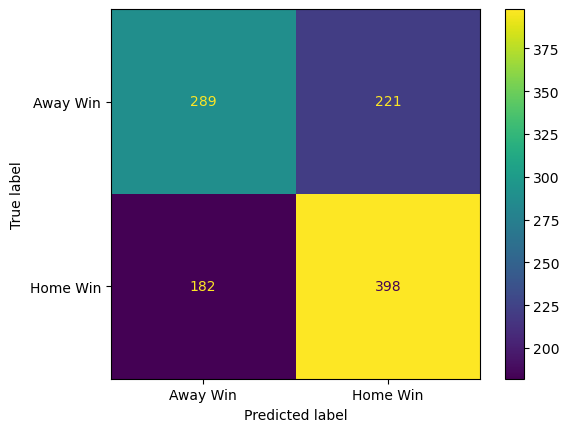

In [11]:
from sklearn import linear_model
filter_base = ["GS","GA","GD","Win%","xGoalsPercentage","corsiPercentage","fenwickPercentage","shotAttemptsFor","shotAttemptsAgainst","xReboundsFor","xReboundsAgainst","xOnGoalFor","xOnGoalAgainst","xGoalsFor","xGoalsAgainst","xReboundsFor","xReboundsAgainst","shotsOnGoalFor","shotsOnGoalAgainst","missedShotsFor","missedShotsAgainst","blockedShotAttemptsFor","blockedShotAttemptsAgainst","takeawaysFor","takeawaysAgainst"]
# filter_base = ["GD","fenwickPercentage","shotsOnGoalFor"]
x = getX(all_game_stats, filter_base)
y = getY(all_game_stats)
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.25)
logr = linear_model.LogisticRegression(C=10, penalty='l1',solver='saga',max_iter=5000)
logr.fit(x_train,y_train)
y_pred = logr.predict(x_test)

print("Testing: ", accuracy_score(y_train,logr.predict(x_train)))
print("Traing:  ", accuracy_score(y_test,y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = ["Away Win", "Home Win"])
cm_display.plot()
plt.show()

In [145]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2','elasticnet'], 'fit_intercept': [True, False], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
grid_search = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


c:\Users\dorgerp\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\dorgerp\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\dorgerp\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\dorgerp\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\dorgerp\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\dorgerp\AppData\Local

Best Parameters: {'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy:  0.6307246651653431


In [13]:
def getTeam(team, stats):
    return stats.loc[stats["team"] == team]

def getGameSet(awayTeam, homeTeam):
    awayTeam = awayTeam.drop(["team"], axis=1)
    homeTeam = homeTeam.drop(["team"], axis=1)
    diff = pd.DataFrame(np.subtract(homeTeam.values, awayTeam.values), columns=homeTeam.columns)
    return diff
    
away = getTeam("Dallas Stars", teamdata25)
home = getTeam("Vegas Golden Knights", teamdata25)
gameSet = getGameSet(away, home)    
print(logr.predict(getX(gameSet, filter_base).values))
getX(gameSet, filter_base)

[1]


,GS,GA,GD,Win%,xGoalsPercentage,corsiPercentage,fenwickPercentage,shotAttemptsFor,shotAttemptsAgainst,xReboundsFor,xReboundsAgainst,xOnGoalFor,xOnGoalAgainst,xGoalsFor,xGoalsAgainst,xReboundsFor,xReboundsAgainst,shotsOnGoalFor,shotsOnGoalAgainst,missedShotsFor,missedShotsAgainst,blockedShotAttemptsFor,blockedShotAttemptsAgainst,takeawaysFor,takeawaysAgainst
0,-0.252614,-0.229574,-0.425411,-0.402055,-0.402717,-0.403177,-0.402832,-0.98988,3.871468,-0.40191,-0.294891,-0.309867,1.336079,-0.380483,-0.255494,-0.40191,-0.294891,0.162098,0.738087,-0.840123,0.991523,-1.116597,1.337116,-0.356292,-0.275653
